2023-01-13 11:46:40.004818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/x86_64-linux-gnu/:/usr/lib/cuda/lib64:/usr/lib/x86_64-linux-gnu/:
2023-01-13 11:46:40.005337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/x86_64-linux-gnu/:/usr/lib/cuda/lib64:/usr/lib/x86_64-linux-gnu/:
2023-01-13 11:46:40.005829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/x86_64-linux-gnu/:/usr/lib/cuda/lib

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
None
Found 17000 images belonging to 10 class

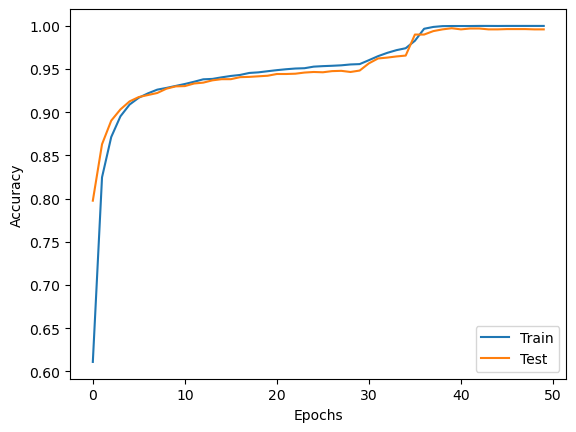

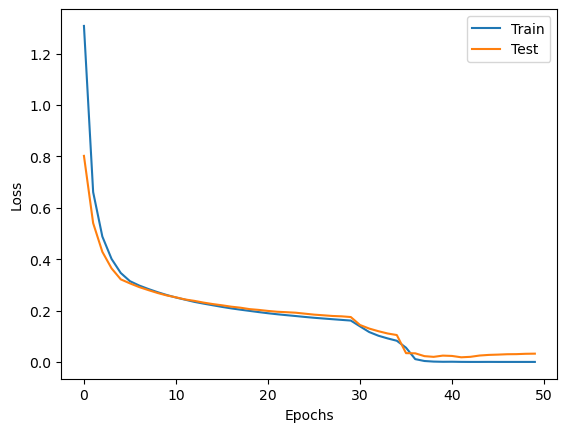

Text(0.5, 14.581597222222216, 'Predicted Class')

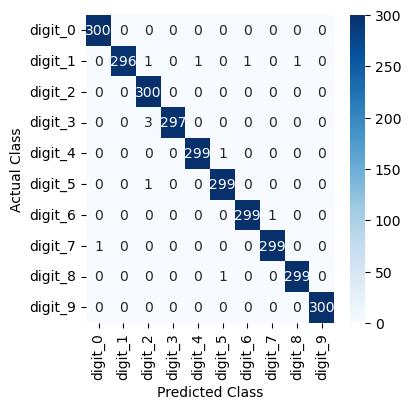

In [2]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, DenseNet121

# custom learning rates
import learning_rate as lr

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
nb_train_samples = 17000
nb_validation_samples = 3000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

# set seeds for reproduceability
np.random.seed(1)
tensorflow.random.set_seed(1)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 75, 75
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
base_model = InceptionV3(include_top=False, input_shape=input_shape)
base_model.trainable = False
inputs = tensorflow.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
outputs = tensorflow.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=13)
validation_generator = val_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=nb_validation_samples,
                    color_mode="rgb",
                    shuffle=False,
                    class_mode='categorical')

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
# model.save_weights('./results/HCR-Net-I.h5')

#################################
#### TRAINING PHASE - II #########
#################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
base_model.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
model.save_weights('./results/HCR-Net-II.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
##############################################################################

In [3]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9960306446635079
recall_score   :  0.9959999999999999
f1_score       :  0.9960010094789373
accuracy_score :  0.996

Best accuracy  :  0.9973333477973938


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
None
Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Epoch 1/30
531/5

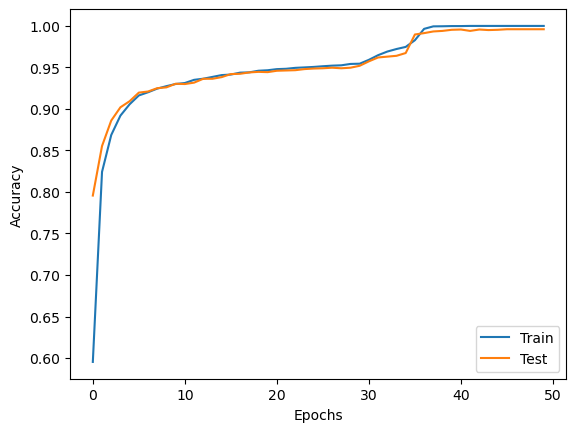

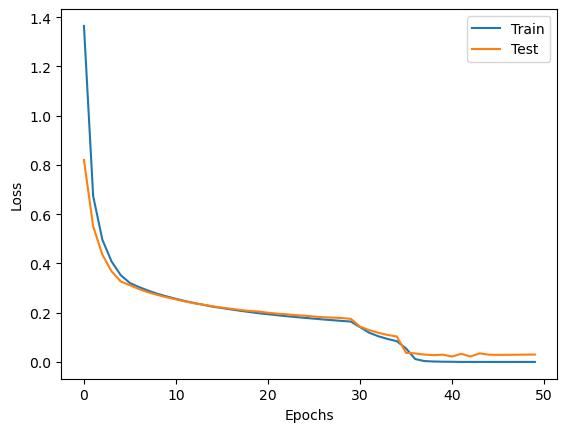

Text(0.5, 14.581597222222216, 'Predicted Class')

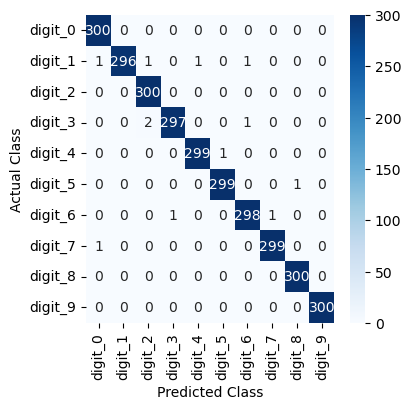

In [4]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, DenseNet121

# custom learning rates
import learning_rate as lr

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
nb_train_samples = 17000
nb_validation_samples = 3000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

# set seeds for reproduceability
np.random.seed(2)
tensorflow.random.set_seed(2)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 75, 75
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
base_model = InceptionV3(include_top=False, input_shape=input_shape)
base_model.trainable = False
inputs = tensorflow.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
outputs = tensorflow.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=13)
validation_generator = val_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=nb_validation_samples,
                    color_mode="rgb",
                    shuffle=False,
                    class_mode='categorical')

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
# model.save_weights('./results/HCR-Net-I.h5')

#################################
#### TRAINING PHASE - II #########
#################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
base_model.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
model.save_weights('./results/HCR-Net-II.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
##############################################################################

In [5]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9960131862843833
recall_score   :  0.9960000000000001
f1_score       :  0.9959971683701522
accuracy_score :  0.996

Best accuracy  :  0.9959999918937683


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
None
Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Epoch 1/30
531/5

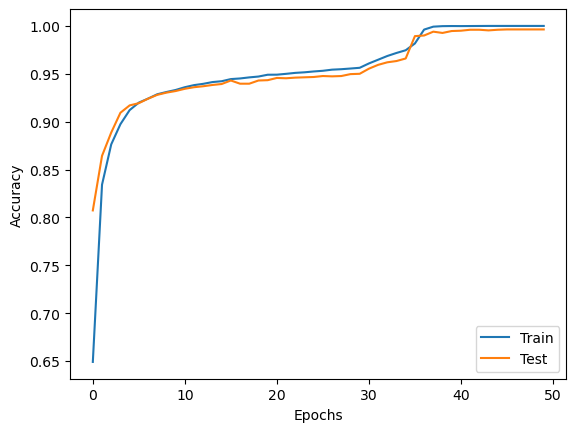

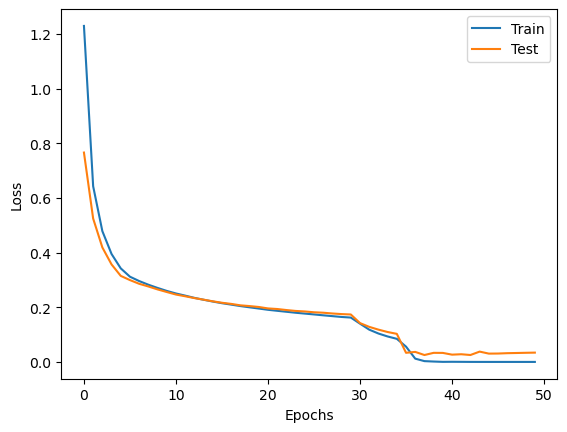

Text(0.5, 14.581597222222216, 'Predicted Class')

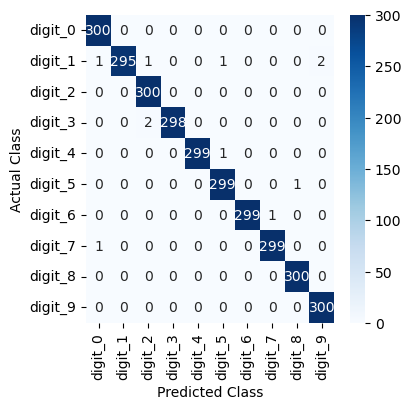

In [6]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, DenseNet121

# custom learning rates
import learning_rate as lr

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
nb_train_samples = 17000
nb_validation_samples = 3000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

# set seeds for reproduceability
np.random.seed(3)
tensorflow.random.set_seed(3)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 75, 75
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
base_model = InceptionV3(include_top=False, input_shape=input_shape)
base_model.trainable = False
inputs = tensorflow.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
outputs = tensorflow.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=13)
validation_generator = val_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=nb_validation_samples,
                    color_mode="rgb",
                    shuffle=False,
                    class_mode='categorical')

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
# model.save_weights('./results/HCR-Net-I.h5')

#################################
#### TRAINING PHASE - II #########
#################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
base_model.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
model.save_weights('./results/HCR-Net-II.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
##############################################################################

In [7]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9963553866046437
recall_score   :  0.9963333333333333
f1_score       :  0.9963304708859375
accuracy_score :  0.9963333333333333

Best accuracy  :  0.9963333606719971


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
None
Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Epoch 1/30
531/5

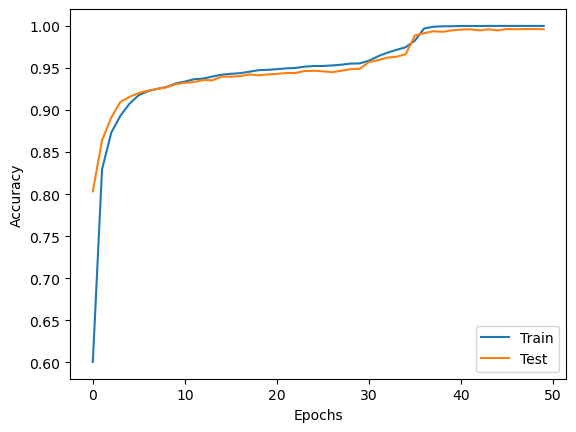

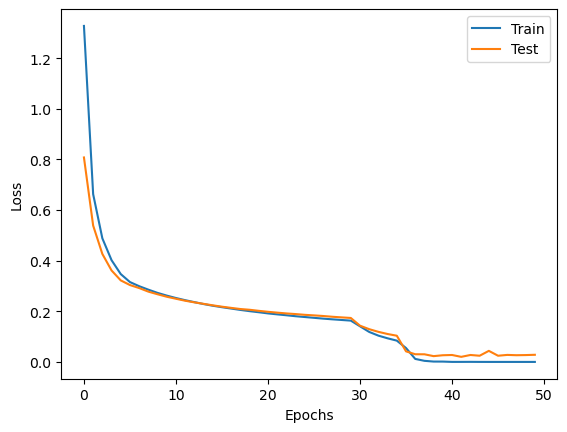

Text(0.5, 14.581597222222216, 'Predicted Class')

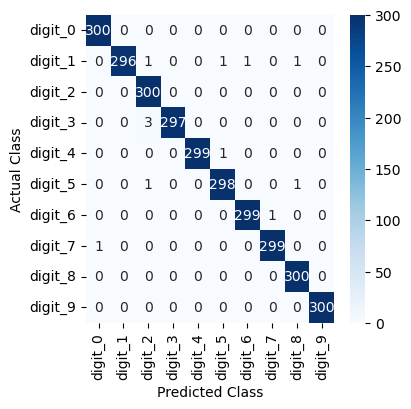

In [8]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, DenseNet121

# custom learning rates
import learning_rate as lr

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
nb_train_samples = 17000
nb_validation_samples = 3000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

# set seeds for reproduceability
np.random.seed(4)
tensorflow.random.set_seed(4)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 75, 75
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
base_model = InceptionV3(include_top=False, input_shape=input_shape)
base_model.trainable = False
inputs = tensorflow.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
outputs = tensorflow.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=13)
validation_generator = val_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=nb_validation_samples,
                    color_mode="rgb",
                    shuffle=False,
                    class_mode='categorical')

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
# model.save_weights('./results/HCR-Net-I.h5')

#################################
#### TRAINING PHASE - II #########
#################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
base_model.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
model.save_weights('./results/HCR-Net-II.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
##############################################################################

In [9]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9960328448351211
recall_score   :  0.9960000000000001
f1_score       :  0.9960010067103806
accuracy_score :  0.996

Best accuracy  :  0.9963333606719971


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
None
Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Epoch 1/30
531/5

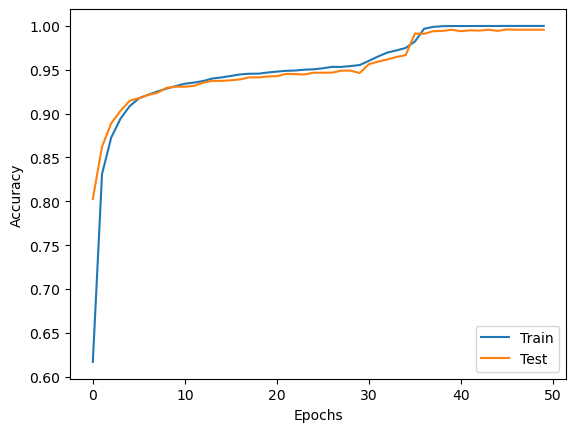

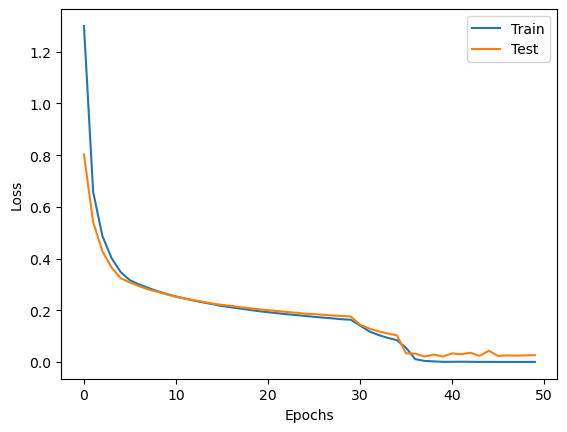

Text(0.5, 14.581597222222216, 'Predicted Class')

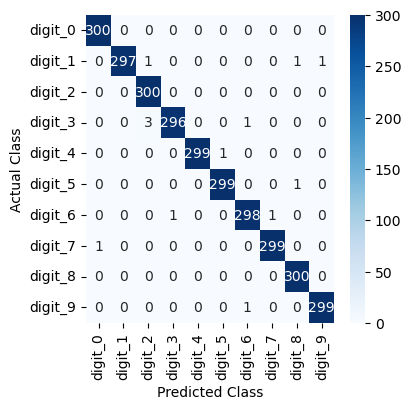

In [10]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, DenseNet121

# custom learning rates
import learning_rate as lr

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = '/home/engs2426/Downloads/HCR-Net-main/Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
nb_train_samples = 17000
nb_validation_samples = 3000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

# set seeds for reproduceability
np.random.seed(5)
tensorflow.random.set_seed(5)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 75, 75
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
base_model = InceptionV3(include_top=False, input_shape=input_shape)
base_model.trainable = False
inputs = tensorflow.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
outputs = tensorflow.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=13)
validation_generator = val_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=nb_validation_samples,
                    color_mode="rgb",
                    shuffle=False,
                    class_mode='categorical')

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
# model.save_weights('./results/HCR-Net-I.h5')

#################################
#### TRAINING PHASE - II #########
#################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
base_model.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
model.save_weights('./results/HCR-Net-II.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
##############################################################################

In [11]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9956863659536983
recall_score   :  0.9956666666666667
f1_score       :  0.9956654880039835
accuracy_score :  0.9956666666666667

Best accuracy  :  0.9959999918937683
